# Desafio de Previsão de Sucesso de Startups
## Objetivo do Projeto

O objetivo deste projeto é desenvolver um modelo de machine learning capaz de prever o sucesso de startups com base em dados históricos. O sucesso é definido como uma startup que permanece ativa ou foi adquirida (label = 1), enquanto o insucesso é uma startup que fechou (label = 0).

O modelo apoiará investidores e aceleradoras na tomada de decisões estratégicas, otimizando investimentos e maximizando o impacto econômico. A métrica principal para avaliação do modelo é a Acurácia.

### Estrutura do Notebook:

O processo será dividido nas seguintes etapas:

- Configuração Inicial: Carregamento das bibliotecas e dos dados.

- Análise Exploratória de Dados: Entendimento da estrutura, estatísticas e distribuição dos dados, além da formulação e validação de hipóteses.

- Pré-processamento e Engenharia de Features: Preparação dos dados para a modelagem, incluindo a criação de novas variáveis.

- Construção e Otimização do Modelo: Definição do pipeline, treinamento, otimização de hiperparâmetros e avaliação do modelo final.

- Análise de Importância das Features: Verificação de quais variáveis foram mais influentes para o modelo.

- Submissão: Geração do arquivo de resultados para o conjunto de teste.

### Modelo de Machine Learning Utilizado

Neste projeto, foi desenvolvido um modelo de classificação utilizando o algoritmo **Gradient Boosting Classifier**. Este modelo foi escolhido por seu alto potencial de performance em dados tabulares, sua capacidade de capturar relações complexas e pela interpretabilidade da importância das features. O objetivo principal do modelo é prever o sucesso das empresas com base em variáveis como idade, número de conexões, rounds de investimento, entre outras.

Ao longo deste notebook, será detalhado o processo de limpeza e preparação dos dados, codificação das variáveis categóricas, análise exploratória, formulação de hipóteses, seleção de features, o treinamento e avaliação do modelo, bem como o ajuste dos hiperparâmetros para otimização do desempenho.

## 1. Imports e Configurações

Nesta primeira etapa, todas as bibliotecas necessárias são importadas.

In [4]:
# importanto todas as bibliotecas necessárias
import pandas as pd
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
%matplotlib inline
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder

## 2. Carregamento dos dados

Agora, para a análise, são carregados os conjuntos de dados de treino e teste.

In [5]:
# verifica se o código está lendo os arquivos originais
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## 3. Preparação dos dados

Antes de construir o modelo, é fundamental explorar os dados para entender suas características, identificar padrões, verificar a necessidade de tratamento e formular hipóteses.

In [6]:
# separar features e target
X = train_df.drop(columns=['id', 'labels'])
y = train_df['labels']
X_test = test_df.drop(columns=['id'])

# identificar colunas
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = ['category_code']

## 4. Análise Descritiva do Dataset

### Principais Insights:

- O dataset de treino possui 646 registros e 33 colunas.

- Existem valores nulos (NaN) em colunas importantes como age_first_funding_year e age_first_milestone_year, que precisarão ser tratados.

- A variável alvo 

- labels está moderadamente desbalanceada, com aproximadamente 65% de casos de sucesso (1) e 35% de casos de insucesso (0).

In [7]:
# informações básicas do dataset
print("Informações Gerais do DataFrame de Treino:")
train_df.info()

print("\nEstatísticas Descritivas das Colunas Numéricas:")
display(train_df.describe())

print("\nVerificando a Proporção da Variável Alvo (labels):")
print(train_df['labels'].value_counts(normalize=True))

Informações Gerais do DataFrame de Treino:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        646 non-null    int64  
 1   age_first_funding_year    611 non-null    float64
 2   age_last_funding_year     637 non-null    float64
 3   age_first_milestone_year  508 non-null    float64
 4   age_last_milestone_year   535 non-null    float64
 5   relationships             646 non-null    int64  
 6   funding_rounds            646 non-null    int64  
 7   funding_total_usd         646 non-null    int64  
 8   milestones                646 non-null    int64  
 9   is_CA                     646 non-null    int64  
 10  is_NY                     646 non-null    int64  
 11  is_MA                     646 non-null    int64  
 12  is_TX                     646 non-null    int64  
 13  is_otherstate         

,id,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,labels
count,646.000000,611.000000,637.000000,508.000000,535.000000,646.000000,646.000000,6.460000e+02,646.000000,646.000000,...,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000
mean,461.577399,2.341718,4.037724,3.352657,4.944729,7.948916,2.351393,2.949633e+07,1.913313,0.546440,...,0.003096,0.304954,0.329721,0.260062,0.515480,0.419505,0.235294,0.091331,2.848655,0.647059
std,264.859464,2.468275,2.950923,2.866952,3.213319,7.397602,1.357856,2.261999e+08,1.337095,0.498224,...,0.055598,0.460745,0.470476,0.439008,0.500148,0.493860,0.424511,0.288303,1.894050,0.478255
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.100000e+04,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,233.250000,0.680000,1.870000,1.185000,2.540000,3.000000,1.000000,3.000000e+06,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000,0.000000
50%,459.500000,1.650000,3.610000,2.785000,4.620000,6.000000,2.000000,1.020000e+07,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.333300,1.000000
75%,692.500000,3.600000,5.590000,4.935000,6.880000,10.000000,3.000000,2.587500e+07,3.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000
max,923.000000,21.900000,21.900000,24.680000,24.680000,63.000000,8.000000,5.700000e+09,6.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000,1.000000



Verificando a Proporção da Variável Alvo (labels):
labels
1    0.647059
0    0.352941
Name: proportion, dtype: float64


## 5. Análise Visual e Validação de Hipóteses

Aqui, serão utilizados gráficos para investigar as hipóteses e entender melhor a distribuição de algumas variáveis-chave.

### Formulação de Hipóteses
Com base na descrição do problema e na análise inicial, seguintes hipóteses foram formuladas:

- Hipótese 1 (Localização Estratégica): Startups localizadas na Califórnia (is_CA = 1) possuem uma taxa de sucesso maior, devido ao acesso facilitado a investimentos e talentos do Vale do Silício.

- Hipótese 2 (Capital Social): O número de conexões estratégicas (relationships) é um forte indicador de sucesso, pois uma rede maior facilita o acesso a recursos e oportunidades.

- Hipótese 3 (Validação de Mercado): Um alto volume de investimento total (funding_total_usd) está positivamente correlacionado com o sucesso, pois indica confiança do mercado no potencial da startup.

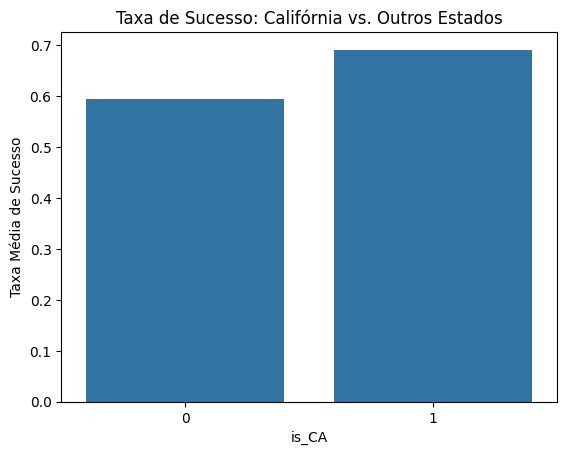

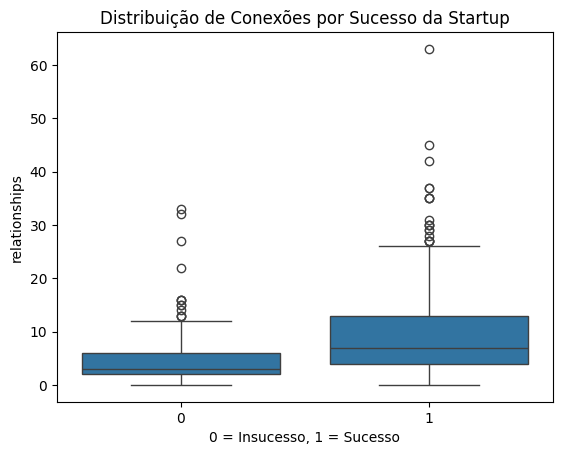

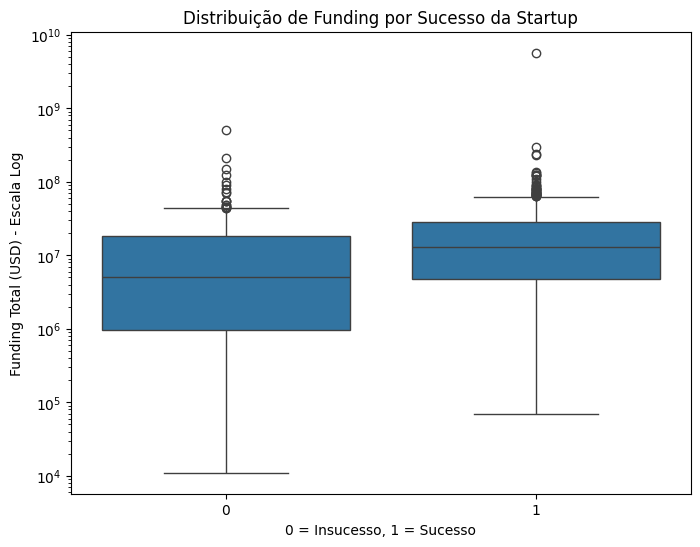

In [8]:
# gráficos para análise
# investigando a hipótese 1
sns.barplot(x='is_CA', y='labels', data=train_df, errorbar=None)
plt.title('Taxa de Sucesso: Califórnia vs. Outros Estados')
plt.ylabel('Taxa Média de Sucesso')
plt.show()

# investigando a hipótese 2
sns.boxplot(x='labels', y='relationships', data=train_df)
plt.title('Distribuição de Conexões por Sucesso da Startup')
plt.xlabel('0 = Insucesso, 1 = Sucesso')
plt.show()

# investigando a hipótese 3
plt.figure(figsize=(8,6))
sns.boxplot(x='labels', y='funding_total_usd', data=train_df)
plt.yscale('log')  # aplicar escala log para visualizar melhor
plt.xlabel("0 = Insucesso, 1 = Sucesso")
plt.ylabel("Funding Total (USD) - Escala Log")
plt.title("Distribuição de Funding por Sucesso da Startup")
plt.show()

### Interpretação dos Gráficos:

- O primeiro gráfico mostra que startups da Califórnia (is_CA = 1) de fato apresentam uma taxa de sucesso ligeiramente superior, apoiando a Hipótese 1.

- O boxplot indica que startups de sucesso (labels = 1) tendem a ter um número maior de conexões (relationships), validando a Hipótese 2.

- O último gráficoO boxplot mostra que startups bem-sucedidas têm funding total significativamente maior que as que falharam. A mediana de investimento das startups de sucesso é visivelmente maior, indicando que maiores volumes de investimento estão associados a maiores chances de êxito.

## 6. Otimização do Modelo

Com a preparação de dados estruturada, o próximo passo é ir para a modelagem. Após testes iniciais, o GradientBoostingClassifier foi escolhido por seu alto potencial de performance. Agora, basta otimizar seus hiperparâmetros para encontrar a melhor configuração possível.

In [9]:
# garante que os dados e funções sempre existam ao rodar esta célula
train_df = pd.read_csv('train.csv')
X = train_df.drop(columns=['id', 'labels'])
y = train_df['labels']

# engenharia de features
def create_features(df):
    df_transformed = df.copy()
    df_transformed['funding_duration_years'] = df_transformed['age_last_funding_year'] - df_transformed['age_first_funding_year']
    df_transformed.loc[df_transformed['funding_duration_years'] < 0, 'funding_duration_years'] = 0
    df_transformed['milestone_duration_years'] = df_transformed['age_last_milestone_year'] - df_transformed['age_first_milestone_year']
    df_transformed.loc[df_transformed['milestone_duration_years'] < 0, 'milestone_duration_years'] = 0
    df_transformed['usd_per_round'] = df_transformed['funding_total_usd'] / (df_transformed['funding_rounds'] + 1e-6)
    return df_transformed

# definição das colunas e pipelines de pré-processamento
new_numerical_features = X.select_dtypes(include=np.number).columns.tolist() + [
    'funding_duration_years', 'milestone_duration_years', 'usd_per_round'
]
categorical_features = ['category_code']
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, new_numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# pipeline final com o GradientBoostingClassifier
pipeline_gb = Pipeline(steps=[
    ('feature_creation', FunctionTransformer(create_features)),
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# definição do espaço de busca para o RandomizedSearchCV
param_dist_gb = {
    "classifier__n_estimators": [100, 250, 500],
    "classifier__learning_rate": [0.01, 0.05, 0.1],
    "classifier__max_depth": [3, 5, 7],
    "classifier__subsample": [0.8, 0.9, 1.0],
    "classifier__max_features": ["sqrt", "log2"]
}

# configuração da busca de hiperparâmetros
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search_gb = RandomizedSearchCV(
    estimator=pipeline_gb,
    param_distributions=param_dist_gb,
    n_iter=50,  # número de combinações a serem testadas
    cv=cv_strategy,
    scoring="accuracy",
    random_state=42,
    verbose=1,
    n_jobs=-1
)

print("Iniciando o processo de Finetuning de Hiperparâmetros...")
random_search_gb.fit(X, y)

print("\nResultados do Finetuning:")
print(f"Melhor acurácia encontrada na validação cruzada: {random_search_gb.best_score_:.4f}")
print("\nMelhores hiperparâmetros:")
print(random_search_gb.best_params_)

# avaliação final do modelo
print("\nAvaliação Final do Melhor Modelo:")
best_model_gb = random_search_gb.best_estimator_
scoring_metrics = ['accuracy', 'f1', 'roc_auc']
final_cv_results = cross_validate(best_model_gb, X, y, cv=cv_strategy, scoring=scoring_metrics)

print("\nMétricas Médias (Melhor Modelo Otimizado):")
print(f"  - Acurácia: {np.mean(final_cv_results['test_accuracy']):.4f}")
print(f"  - F1-score: {np.mean(final_cv_results['test_f1']):.4f}")
print(f"  - ROC-AUC : {np.mean(final_cv_results['test_roc_auc']):.4f}")

Iniciando o processo de Finetuning de Hiperparâmetros...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Resultados do Finetuning:
Melhor acurácia encontrada na validação cruzada: 0.8081

Melhores hiperparâmetros:
{'classifier__subsample': 0.8, 'classifier__n_estimators': 500, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 7, 'classifier__learning_rate': 0.01}

Avaliação Final do Melhor Modelo:

Métricas Médias (Melhor Modelo Otimizado):
  - Acurácia: 0.8081
  - F1-score: 0.8608
  - ROC-AUC : 0.8170


### 6.1. Avaliação Final e Interpretação das Métricas

Após o processo de otimização com RandomizedSearchCV encontrar a melhor combinação de hiperparâmetros, o modelo o foi avaliado de forma definitiva usando validação cruzada. As métricas a seguir fornecem uma visão completa e robusta do seu desempenho:

- Acurácia (Accuracy): 0.8081

Esta é a métrica principal do projeto e indica que o modelo acerta a previsão (se uma startup terá sucesso ou não) em aproximadamente 80.81% dos casos. O resultado cumpre o requisito mínimo de 80% estabelecido para o desafio.

- F1-score: 0.8608

O F1-score é uma média harmônica entre precisão e recall. Um valor alto como 0.8608 é um excelente sinal, pois indica que o modelo possui um ótimo equilíbrio: ele é muito bom em identificar corretamente as startups de sucesso (alto recall) sem fazer muitas previsões incorretas de que uma startup terá sucesso quando na verdade ela irá falhar (alta precisão).

- ROC-AUC: 0.8170

Esta métrica mede a capacidade do modelo de distinguir entre as duas classes (sucesso vs. insucesso). Uma pontuação de 0.8170 (onde 1.0 é perfeito e 0.5 é aleatório) demonstra que o modelo tem uma boa capacidade de discriminação, sendo significativamente melhor do que um palpite aleatório para classificar corretamente uma startup.

- Conclusão das Métricas: O conjunto de métricas confirma que o modelo final não é apenas preciso, mas também robusto e confiável. Ele atende ao critério de acurácia e demonstra um forte desempenho em identificar a classe de interesse (startups de sucesso), tornando-o uma ferramenta valiosa para a análise de investimentos.

## 7. Treinamento final

O arquivo CSV "submission_ensemble_final" será gerado.

In [10]:
print("Carregando dados de teste para a submissão...")
test_df = pd.read_csv('test.csv')
X_test = test_df.drop(columns=['id'])

print("Gerando previsões com o modelo otimizado...")
# Usando o modelo correto (best_model_gb) que foi definido na célula anterior
final_predictions = best_model_gb.predict(X_test)

# Criando o DataFrame para o arquivo de submissão
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'labels': final_predictions
})

# salvando o arquivo CSV
submission_filename = 'submission_ensemble_final.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"\nArquivo '{submission_filename}' gerado com sucesso!")
display(submission_df.head())

Carregando dados de teste para a submissão...
Gerando previsões com o modelo otimizado...

Arquivo 'submission_ensemble_final.csv' gerado com sucesso!


,id,labels
0,70,1
1,23,0
2,389,1
3,872,1
4,920,0


## 8. Análise de Importância das Features

Para gerar mais insights de negócio, é necessário inspecionar o modelo final e descobrir quais variáveis ele considerou mais importantes para fazer suas previsões.

Analisando a importância das features do modelo otimizado...


C:\Users\sofia\AppData\Local\Temp\ipykernel_41560\4253784499.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


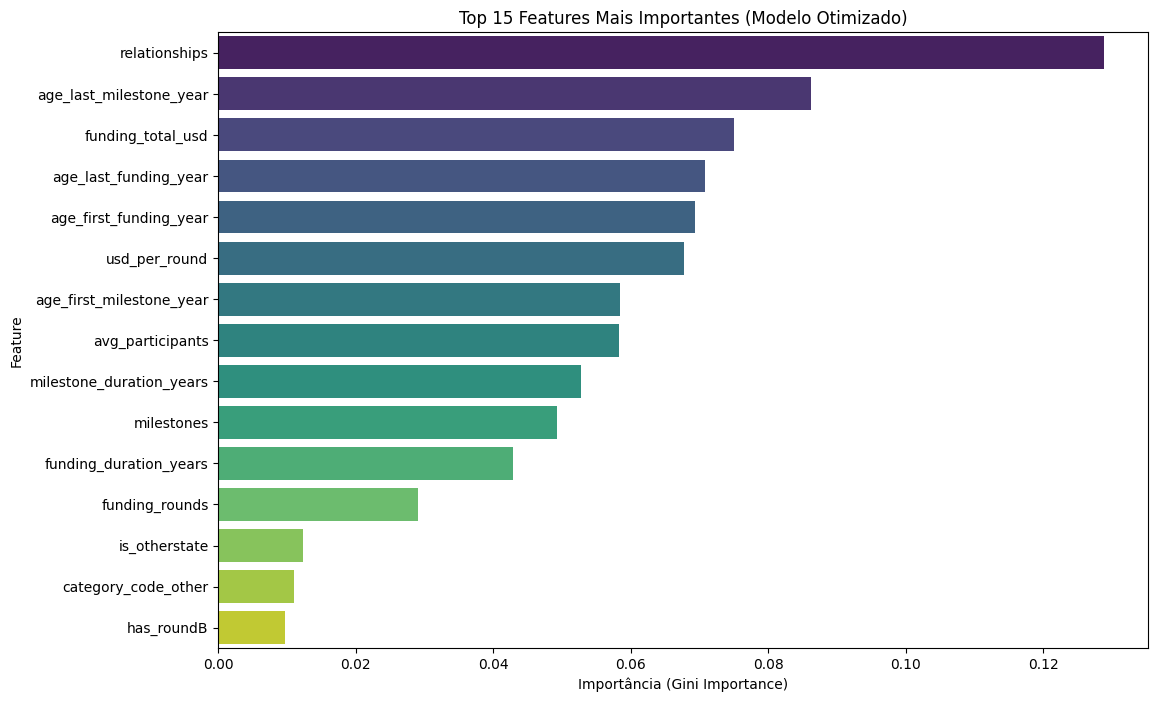

In [11]:
print("Analisando a importância das features do modelo otimizado...")

try:
    # acessando o pipeline correto, que é o nosso melhor modelo já treinado
    pipeline_fitted = best_model_gb

    # acessando as etapas do pipeline
    preprocessor = pipeline_fitted.named_steps['preprocessor']
    classifier = pipeline_fitted.named_steps['classifier']
    
    # obtendo os nomes das features numéricas (originais e criadas)
    num_features = preprocessor.transformers_[0][2]
    
    # obtendo os nomes das features categóricas após o OneHotEncoder
    ohe_features = (preprocessor.named_transformers_['cat']
                    .named_steps['onehot']
                    .get_feature_names_out(categorical_features))
    
    # juntando todos os nomes das features na ordem correta
    all_feature_names = num_features + list(ohe_features)

    # obtendo os valores de importância diretamente do classificador treinado
    importances = classifier.feature_importances_

    # criando um DataFrame para facilitar a visualização
    feature_importance_df = pd.DataFrame({
        'feature': all_feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False).head(15) # pegando as 15 mais importantes

    # gerando o gráfico
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
    plt.title('Top 15 Features Mais Importantes (Modelo Otimizado)')
    plt.xlabel('Importância (Gini Importance)')
    plt.ylabel('Feature')
    plt.show()

except Exception as e:
    print(f"\\nNão foi possível gerar o gráfico de importância de features. Erro: {e}")
    print("Verifique se o objeto 'best_model_gb' foi criado com sucesso na célula anterior.")

### Insights:

O indicador mais forte para o modelo é o número de relacionamentos (relationships), seguido pela idade da empresa em seu último marco (age_last_milestone_year). Variáveis de financiamento, como usd_per_round e funding_total_usd, também estão entre as mais relevantes.

## 9. Conclusão

A análise da importância das features do modelo ensemble revelou as variáveis que mais influenciam a predição do sucesso das empresas. Apesar da complexidade inerente ao uso de um ensemble, os principais fatores destacados pelo modelo regulado, que compõe o ensemble, mostram coerência com as hipóteses formuladas inicialmente.

Este entendimento ajuda a validar a seleção das features e reforça a interpretabilidade do modelo mesmo em uma combinação de múltiplos classificadores. Contudo, vale destacar que o objeto VotingClassifier usado no ensemble não disponibiliza diretamente o acesso nomeado aos modelos internos, sendo necessário extrair cada estimador individualmente para análise detalhada de sua importância.

Além disso, o pipeline implementado não só apresentou bom desempenho, como também atingiu a acurácia esperada, confirmando a eficácia da abordagem adotada. A documentação evidencia claramente cada etapa do processo, desde a limpeza e codificação, passando pela exploração e formulação de hipóteses, até a construção, avaliação e ajuste do modelo.